<div align='center'>
    <img src='https://images.adsttc.com/media/images/5ecd/d4ac/b357/65c6/7300/009d/large_jpg/02C.jpg?1590547607'
</div>

Решение соревнования: https://www.kaggle.com/datasets/muhammadbinimran/housing-price-prediction-data

# 1. Импортируем необходимые библиотеки и загружаем данные.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("housing_price_dataset.csv") 
df.head()

,SquareFeet,Bedrooms,Bathrooms,Neighborhood,YearBuilt,Price
0,2126,4,1,Rural,1969,215355.283618
1,2459,3,2,Rural,1980,195014.221626
2,1860,2,1,Suburb,1970,306891.012076
3,2294,2,1,Urban,1996,206786.787153
4,2130,5,2,Suburb,2001,272436.239065


# 2. EDA (Разведочный анализ данных)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SquareFeet    50000 non-null  int64  
 1   Bedrooms      50000 non-null  int64  
 2   Bathrooms     50000 non-null  int64  
 3   Neighborhood  50000 non-null  object 
 4   YearBuilt     50000 non-null  int64  
 5   Price         50000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 2.3+ MB


Датасет содержит 50000 записей и не имеет пропусков. Но есть признак типа object.

In [4]:
df.Neighborhood.value_counts()

Neighborhood
Suburb    16721
Rural     16676
Urban     16603
Name: count, dtype: int64

В признаке Neighborhood немного уникальных значение. Закодируем позже с помощью LabelEncoder

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
SquareFeet,50000.0,2006.374680,575.513241,1000.000000,1513.000000,2007.000000,2506.000000,2999.000000
Bedrooms,50000.0,3.498700,1.116326,2.000000,3.000000,3.000000,4.000000,5.000000
Bathrooms,50000.0,1.995420,0.815851,1.000000,1.000000,2.000000,3.000000,3.000000
YearBuilt,50000.0,1985.404420,20.719377,1950.000000,1967.000000,1985.000000,2003.000000,2021.000000
Price,50000.0,224827.325151,76141.842966,-36588.165397,169955.860225,225052.141166,279373.630052,492195.259972


Очень сильно выделяется признак Price на фоне остальных. Подозрение на выбросы.

Text(0.5, 1.0, 'Column: Price')

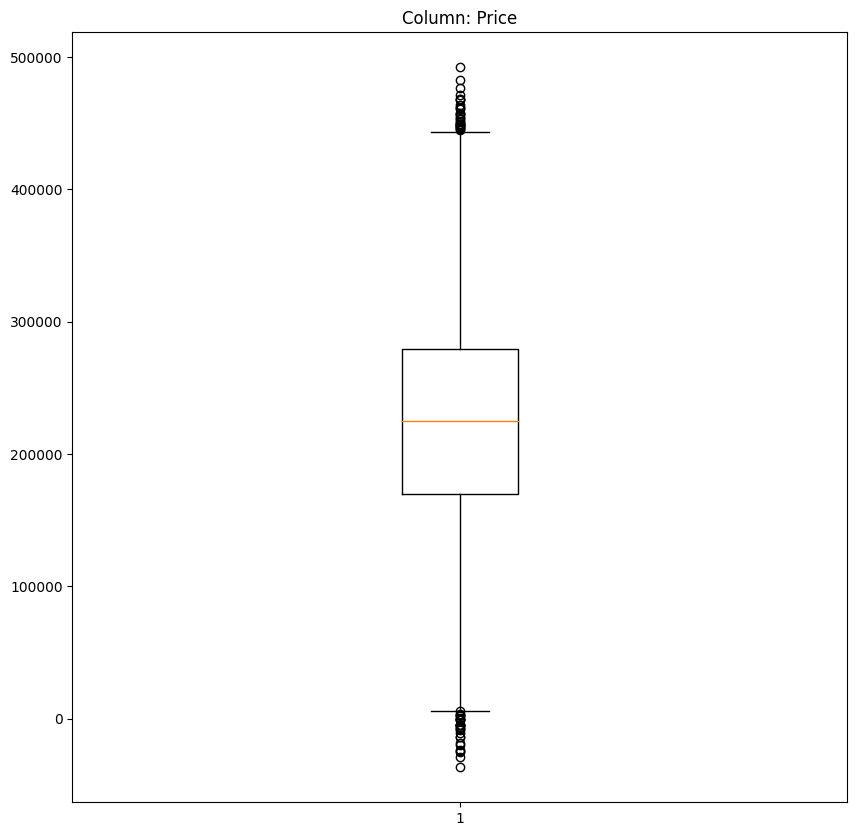

In [6]:
plt.figure(figsize=(10,10))
plt.boxplot(df.Price)
plt.title('Column: Price')

По итогу присутствуют выбросы. Цена отрицательная? Получается нам платят за то, что мы оформляем на себя участок. Ребята, я пошёл делать деньги😂

<Axes: >

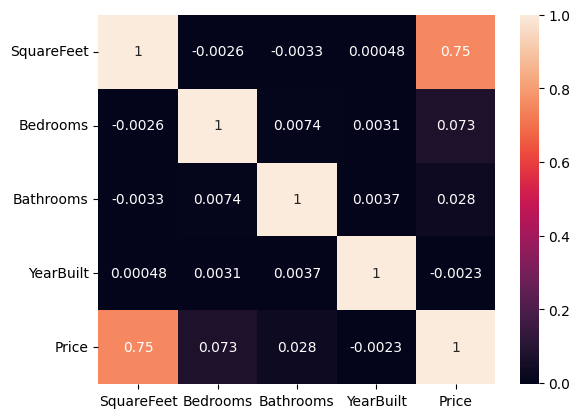

In [7]:
sns.heatmap(df.drop('Neighborhood', axis=1).corr(), annot=True)

Можно заметить, что признаки между собой слабо коррелируют. На целевой признак очень сильно влияет признак SquareFeet

In [8]:
dublicate_data = df[df.drop('Price', axis=1).duplicated(keep=False)].sort_values(['SquareFeet', 'Bedrooms', 'Neighborhood', 'YearBuilt', 'Price'])
print(f"Количество домов с одинаковыми параметрами, но разной стоимостью: {dublicate_data.shape[0]}")
dublicate_data.head(20)

Количество домов с одинаковыми параметрами, но разной стоимостью: 461


,SquareFeet,Bedrooms,Bathrooms,Neighborhood,YearBuilt,Price
38621,1020,2,2,Suburb,1963,132662.437768
40114,1020,2,2,Suburb,1963,152360.276197
19765,1022,4,1,Urban,1955,125182.921855
30579,1022,4,1,Urban,1955,189550.528832
44058,1024,2,2,Suburb,2005,62628.424230
6383,1024,2,2,Suburb,2005,134253.856692
39633,1026,5,1,Suburb,2007,161247.797257
16844,1026,5,1,Suburb,2007,191654.759737
30423,1043,5,3,Rural,1978,115183.430539
48076,1043,5,3,Rural,1978,128904.872768


В датасете присутствуют одинаковые дома но по различной цене. 

# 3. Обработка датасета.

In [9]:
df.drop(df[df.Price <= 0].index, axis=0, inplace=True) # Удалим дома с отрицательной ценой

In [10]:
df.drop_duplicates(keep=False, inplace=True) # Удалим все записи содержащие дубликаты

In [11]:
df.Neighborhood = LabelEncoder().fit_transform(df.Neighborhood) # Закодируем признак Neighborhood
df.head()

,SquareFeet,Bedrooms,Bathrooms,Neighborhood,YearBuilt,Price
0,2126,4,1,0,1969,215355.283618
1,2459,3,2,0,1980,195014.221626
2,1860,2,1,1,1970,306891.012076
3,2294,2,1,2,1996,206786.787153
4,2130,5,2,1,2001,272436.239065


# 4. Формирование выборок и обучение моделей

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df.drop("Price", axis=1), df.Price, 
                                                    test_size=0.2, random_state=42)

In [13]:
models = [
    MLPRegressor(),
    XGBRegressor(),
    LinearRegression(),
    RandomForestRegressor(),
    KNeighborsRegressor()
]

In [14]:
best_model = None # Лучшая модель
best_score = None # Точность у лучшей модели
best_loss = None # Ошибка у лучшей модели
for clf in models:
    clf.fit(X_train, y_train) 
    y_pred = clf.predict(X_test)

    # Высчитываем метрики
    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print(f"{clf.__class__.__name__:30}: R2_score: {r2:17}, RMSE: {round(rmse, 6):10}")

    # Проверям на лучшую модель
    if best_loss != None:
        if best_loss > rmse:
            best_model = clf
            best_score = r2
            best_loss = rmse
    else:
        best_model = clf
        best_score = r2
        best_loss = rmse

# Выводим лучшую модель
print("-"*92)
print(f"{best_model.__class__.__name__:30}: R2_score: {best_score}, RMSE: {round(best_loss, 6):10}")

MLPRegressor                  : R2_score: 0.5746426707498735, RMSE: 49635.105175
XGBRegressor                  : R2_score: 0.5581297376328026, RMSE: 50589.381945
LinearRegression              : R2_score: 0.5778358738000487, RMSE: 49448.446171
RandomForestRegressor         : R2_score: 0.5227804521767397, RMSE: 52574.009429
KNeighborsRegressor           : R2_score: 0.4897118054741789, RMSE: 54365.044366
--------------------------------------------------------------------------------------------
LinearRegression              : R2_score: 0.5778358738000487, RMSE: 49448.446171


По итогу обучения моделей "из коробки" модель LinearRegression показала лучший результат..

# 5. Подбор гиперпараметров у моделей.

In [15]:
model_params = {
    'KNeighborsRegressor' : {
        'model': KNeighborsRegressor(),
        'params': {
            'n_neighbors': [1,3,5,7,10,12,16,17,20,21,25,30,35,40,42,44,48,50,55,59,60]
        }
    },
    'XGBRegressor' : {
        'model': XGBRegressor(),
        'params': {
            'max_depth': range(3,18),
            'gamma': range(1,9),
            'reg_alpha' : range(40,180,40),
            'reg_lambda' : range(0,1)
        }
    },
    'MLPRegressor' : {
        'model': MLPRegressor(),
        'params': {
            "activation": ["identity", "logistic", "tanh", "relu"], 
            "solver": ["lbfgs", "sgd", "adam"], 
            "alpha": [0.00005,0.0005]
        }
    },
    'RandomForestRegressor': {
        'model': RandomForestRegressor(),
        'params' : {
            'n_estimators': [60,100,300,500,700]
        }
    },
}

In [16]:
for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=3, return_train_score=False)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Высчитываем метрики
    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print(f"{model_name:30}: R2_score: {r2:17}, RMSE: {round(rmse, 6):10}")

    # Проверям на лучшую модель
    if best_loss != None:
        if best_loss > rmse:
            best_model = clf.best_estimator_
            best_score = r2
            best_loss = rmse
    else:
        best_model = clf.best_estimator_
        best_score = r2
        best_loss = rmse

# Выводим лучшую модель
print("-"*92)
print(f"{best_model.__class__.__name__:30}: R2_score: {best_score}, RMSE: {round(best_loss, 6):10}")

KNeighborsRegressor           : R2_score: 0.5659196632792411, RMSE: 50141.46779
XGBRegressor                  : R2_score: 0.5757246771972946, RMSE: 49571.935109
MLPRegressor                  : R2_score: 0.5778457886837287, RMSE: 49447.865498
RandomForestRegressor         : R2_score: 0.5274378171087108, RMSE: 52316.835667
--------------------------------------------------------------------------------------------
MLPRegressor                  : R2_score: 0.5778457886837287, RMSE: 49447.865498


После подбора гиперпараметров модель MLPRegressor показа наилучшую точность среди всех моделей.